In [1]:
from itertools import product
from pathlib import Path

import bokeh
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import umap
from bokeh import plotting as bokeh_plotting
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
sns.set_style("darkgrid")
sns.set(font_scale=1.1)

In [3]:
output_dir = Path("../figures")
output_dir.mkdir(exist_ok=True, parents=True)

## Algorithm selection

In [4]:
overview_df = pd.read_csv("../data/frvt_11_overview.csv", index_col=0)

In [5]:
accurate_algorithms = set(
    overview_df[overview_df["Visa, 1e-6"] < 1e-1].index
)

In [6]:
len(accurate_algorithms)

197

## EDA

In [7]:
df = pd.read_csv("../data/frvt_11_cross_region_fmr.csv")

In [8]:
df["pairing"].unique()

array(['any', 'same_age', 'same_sex', 'same_sex_age'], dtype=object)

## Useful functions

In [9]:
def fmr_matrix(df, diag_only=False, flatten=False):    
    fmr = []
    algorithms = []
    for algorithm, group in df.groupby("algorithm"):
        group = group.pivot(index="eregion", columns="vregion", values="fmr")
        fmr.append(group.values)
        algorithms.append(algorithm)
    fmr = np.stack(fmr, axis=0)
    
    if diag_only:
        fmr = np.diagonal(fmr, axis1=-2, axis2=-1)
    if flatten:
        fmr = fmr.reshape((fmr.shape[0], -1))
    
    return fmr, algorithms

In [10]:
def get_algorithm_fmr(df, algorithm, pairing=None):
    df = df.query(f"algorithm == @algorithm")
    if pairing:
        df = df.query(f"pairing == @pairing")
    df = df.pivot(index="eregion", columns="vregion", values="fmr")
    df.name = algorithm
    return df

In [11]:
def plot_fmr(fmr, vmin=-6, vmax=-2, title=None, new_figure=True):
    if new_figure:
        plt.figure(figsize=(6, 4))
    sns.heatmap(fmr, annot=fmr.round(1), vmin=vmin, vmax=vmax, cmap = "vlag")
    plt.xlabel("")
    plt.ylabel("")
    if title:
        plt.title(title)
    elif isinstance(fmr, pd.DataFrame) and hasattr(fmr, "name"):
        plt.title(fmr.name)
    plt.gca().invert_yaxis()
    plt.tight_layout()

## Examples and FMR plots

In [25]:
df = pd.read_csv("../data/frvt_11_cross_region_fmr.csv")
df = df.drop(columns="overall_fmr")

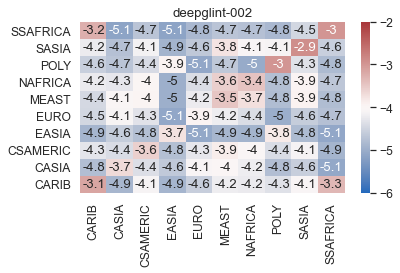

In [36]:
fmr = get_algorithm_fmr(df, "deepglint-002", "any")
plot_fmr(fmr)

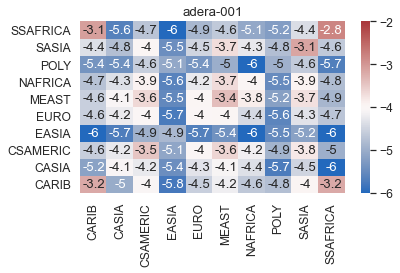

In [37]:
fmr = get_algorithm_fmr(df, "adera-001", "any")
plot_fmr(fmr)

In [39]:
for pairing in df["pairing"].unique():
    plot_dir = output_dir / "fmr_by_region" / pairing
    plot_dir.mkdir(exist_ok=True, parents=True)

    for algorithm in df["algorithm"].unique():
        fmr = get_algorithm_fmr(df, algorithm, pairing)
        plot_fmr(fmr)
        plt.savefig(plot_dir / f"{algorithm.replace('-', '_')}.jpg", dpi=100)
        plt.close()

In [38]:
for pairing in df["pairing"].unique():
    plot_dir = output_dir / "fmr_by_region_mean" / pairing
    plot_dir.mkdir(exist_ok=True, parents=True)

    fmrs, algorithms = fmr_matrix(df.query("pairing == @pairing"))
    fmr_mean = np.mean(fmrs, axis=0)
    
    for algorithm in df["algorithm"].unique():
        fmr = get_algorithm_fmr(df, algorithm, pairing)
        fmr = fmr - fmr_mean
        fmr.name = algorithm
        
        plot_fmr(fmr, vmin=-1, vmax=1)
        plt.savefig(plot_dir / f"{algorithm.replace('-', '_')}.jpg", dpi=100)
        plt.close()

## Find least biased model

In [40]:
df = pd.read_csv("../data/frvt_11_cross_region_fmr.csv")
df = df.drop(columns="overall_fmr")
df = df.query("algorithm in @accurate_algorithms")

In [41]:
pairing = "any"
df = df.query("pairing == @pairing")

In [42]:
fmrs, algorithms = fmr_matrix(df)

In [43]:
def diag_bias(fmr, kind):
    diag = np.diagonal(fmr, axis1=-2, axis2=-1)
    avg = np.mean(diag, axis=-1, keepdims=True)
    if kind == "L1":
        bias = np.mean(np.abs(diag - avg), axis=-1)
    elif kind == "Linf":
        bias = np.max(np.abs(diag - avg), axis=-1)
    elif kind == "Range":
        bias = np.max(diag, axis=-1) - np.min(diag, axis=-1)
    else:
        raise ValueError(f"Unknown value for kind: {kind}.")
    return bias

In [44]:
bias_df = pd.DataFrame({"algorithm": algorithms})
for kind in ["L1", "Linf", "Range"]:
    bias_df[kind] = diag_bias(fmrs, kind)

<Figure size 600x600 with 0 Axes>

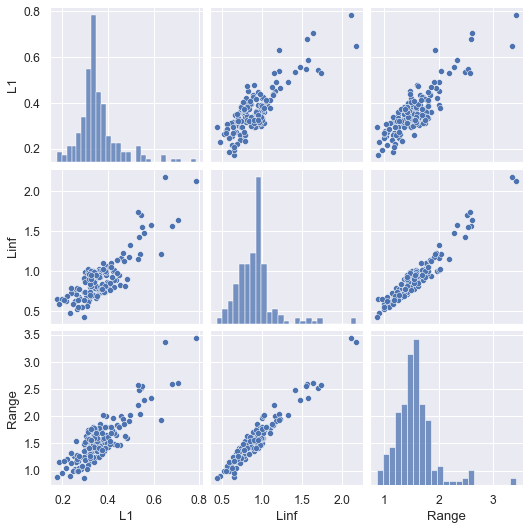

In [45]:
plt.figure(figsize=(3, 3), dpi=200)
sns.pairplot(bias_df)
plt.savefig(output_dir / "frvt_11_region_fmr_pairplot.jpg")

In [46]:
bias_df.sort_values("Linf", ascending=False).head()

,algorithm,L1,Linf,Range
107,mt-002,0.649231,2.178905,3.362399
58,fiberhome-nanjing-002,0.785448,2.118552,3.433064
187,x-laboratory-001,0.532194,1.739522,2.575794
17,anke-005,0.543557,1.695967,2.519873
151,synesis-006,0.704269,1.638572,2.610241


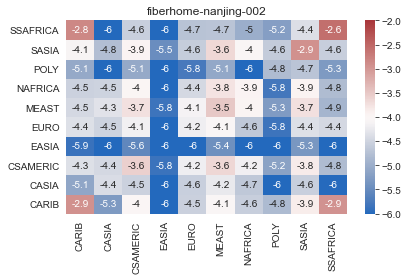

In [41]:
# Leads in both L1 and span, second in Linf
plot_fmr(get_algorithm_fmr(df, "fiberhome-nanjing-002"))

In [47]:
bias_df.sort_values("L1", ascending=True).head()

,algorithm,L1,Linf,Range
143,shu-002,0.174146,0.656574,0.889764
182,vocord-007,0.186549,0.586435,1.167380
147,sjtu-001,0.195950,0.647622,0.954302
189,yitu-003,0.207476,0.645809,1.171069
148,sjtu-002,0.216420,0.631262,1.052099


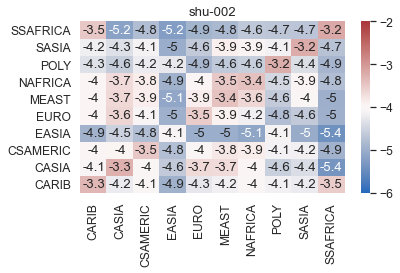

In [48]:
# shu-002 is top in L1, second in span, 18 in Linf
plot_fmr(get_algorithm_fmr(df, "shu-002"))

## UMAP plot

In [64]:
bokeh.io.output_notebook()

Loading BokehJS ...

In [58]:
def plot_umap(df: pd.DataFrame, title: str):
    """Generate the Bokeh figure for UMAP plotting.

    Args:
        df: Dataframe with columns 'x', 'y' and 'filepath'.
        title: Title of graph
    """
    tooltips= f"""
        <img src="@filepath" style="height: 300px; width: 450px" />
    """
    
    p = bokeh_plotting.figure(
        title=title,
        plot_width=600,
        plot_height=400,
        tooltips=tooltips,
        background_fill_color="#fafafa",
        tools="pan,box_zoom,save,reset",
    )

    params = {
        "x": "x",
        "y": "y",
        "alpha": 0.75,
        "size": 8,
        "source": bokeh_plotting.ColumnDataSource(df),
        "line_color": "black",
        "fill_color": "blue",
    }
    p.circle(**params)
    
    return p

In [59]:
df = (
    pd.read_csv("../data/frvt_11_cross_region_fmr.csv")
    .drop(columns="overall_fmr")
    .query("algorithm in @accurate_algorithms")
)

In [60]:
pairing = "any"
df = df.query("pairing == @pairing")

In [61]:
fmr, algorithms = fmr_matrix(df, diag_only=False, flatten=True)

In [73]:
df.head()

,algorithm,pairing,eregion,vregion,fmr
400,3divi-004,any,CARIB,CARIB,-3.425513
401,3divi-004,any,CARIB,CASIA,-5.025121
402,3divi-004,any,CARIB,CSAMERIC,-4.368813
403,3divi-004,any,CARIB,EASIA,-5.293178
404,3divi-004,any,CARIB,EURO,-4.989220


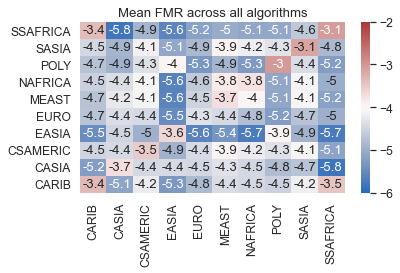

In [75]:
# Mean heatmap
fmr_mean = pd.DataFrame(
    data=fmr.mean(axis=0).reshape((10, 10)),
    index=df["eregion"].unique(),
    columns=df["vregion"].unique(),
)
fmr_mean.name = "Mean FMR across all algorithms"
plot_fmr(fmr_mean)
plt.savefig(output_dir / "frvt_11_region_fmr_mean.jpg")

In [53]:
reducer = umap.UMAP()
emb = reducer.fit_transform(fmr)

In [62]:
plot_df = pd.DataFrame(
    {"x": emb[:, 0], "y": emb[:, 1], "caption": algorithms}
)

In [ ]:
https://martinsbruveris.com/static/nist_frvt_analysis/figures/

In [70]:
plot_dir = str(output_dir / "fmr_by_region_mean" / pairing) + "/"
# plot_dir = (
#     "https://martinsbruveris.com/static/"
#     "nist_frvt_analysis/figures/fmr_by_region_mean/" + pairing + "/"
# )
plot_df["filepath"] = plot_df["caption"].map(
    lambda alg: plot_dir + f"{alg.replace('-', '_')}.jpg"
)

In [71]:
p = plot_umap(
    plot_df, 
    "FMR by region (log10), any impostor pairing, at overall FMR=1e-4."
)
layout = bokeh.layouts.column(p, sizing_mode="scale_width")
bokeh_plotting.show(layout)

In [68]:
html = bokeh.embed.file_html(layout, bokeh.resources.CDN, "my plot")

In [ ]:
print(html)

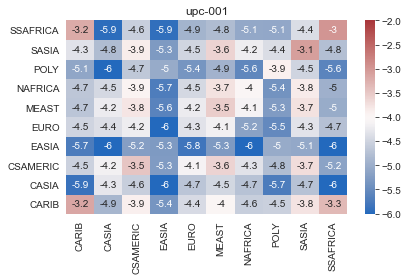

In [98]:
plot_fmr(get_algorithm_fmr(df, "upc-001", pairing))

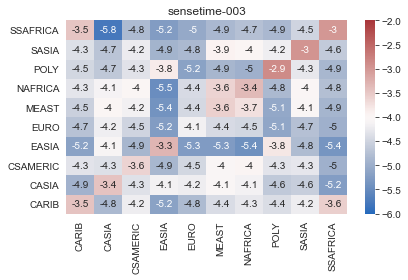

In [99]:
plot_fmr(get_algorithm_fmr(df, "sensetime-003", pairing))

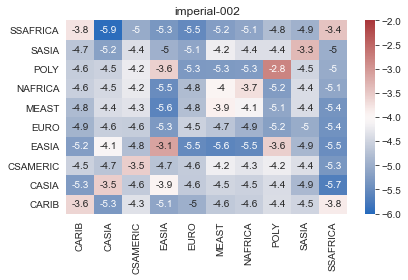

In [102]:
plot_fmr(get_algorithm_fmr(df, "imperial-002", pairing))

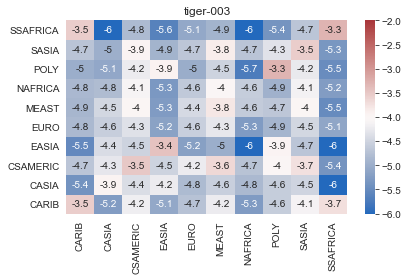

In [103]:
plot_fmr(get_algorithm_fmr(df, "tiger-003", pairing))

## PCA on FMR matrix

In [12]:
df = pd.read_csv("../data/frvt_11_cross_region_fmr.csv")
df = df.drop(columns="overall_fmr")
df = df.query("algorithm in @accurate_algorithms")

In [18]:
n_comp = 10
regions = df["eregion"].unique()
pca_data = []
err_data = []
components = {}

for pairing in df["pairing"].unique():
    pairing_df = df.query("pairing == @pairing")
    
    fmrs, algorithms = fmr_matrix(pairing_df, diag_only=False, flatten=True)
    pca = PCA(n_components=n_comp).fit(fmrs)
    var = pca.explained_variance_ratio_.cumsum()
    
    for n in range(0, n_comp):
        comp = pca.components_[n]
        comp = np.reshape(comp, (len(regions), len(regions)))
        comp = pd.DataFrame(comp, index=regions, columns=regions)
        components[pairing, n] = comp
        
    
    for fmr, algorithm in zip(fmrs, algorithms):
        y = pca.transform(fmr.reshape((1, -1)))
        y_n = np.zeros((1, n_comp))
        for n in range(1, n_comp):
            y_n[:, :n] = y[:, :n]  # We take more and more components of y
            fmr_rec = pca.inverse_transform(y_n)
            err_mean = np.mean(np.abs(fmr - fmr_rec))
            err_max = np.max(np.abs(fmr - fmr_rec))
            err_data.append((algorithm, pairing, n, err_mean, err_max))
    
    pca_data.extend([(pairing, j, v) for j, v in enumerate(var)])
    
pca_df = pd.DataFrame(pca_data, columns=["pairing", "n", "var"])
err_df = pd.DataFrame(
    err_data, columns=["algorithm", "pairing", "n", "mean", "max"]
)

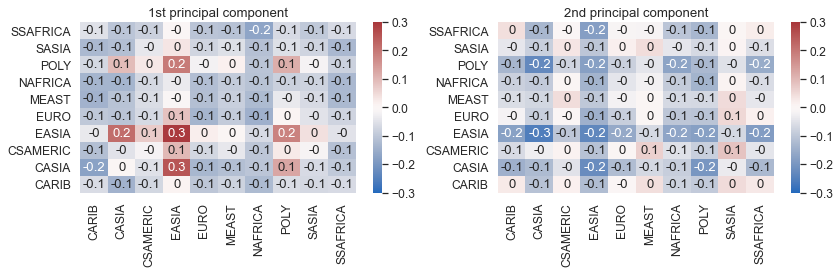

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_fmr(
        components["any", 0], 
        vmin=-0.3, 
        vmax=0.3, 
        title=f"1st principal component",
        new_figure=False,
    )
plt.subplot(1, 2, 2)
plot_fmr(
        components["any", 1], 
        vmin=-0.3, 
        vmax=0.3, 
        title=f"2nd principal component",
        new_figure=False,
    )
plt.savefig(output_dir / "frvt_11_region_pca_1_2.jpg", dpi=100)

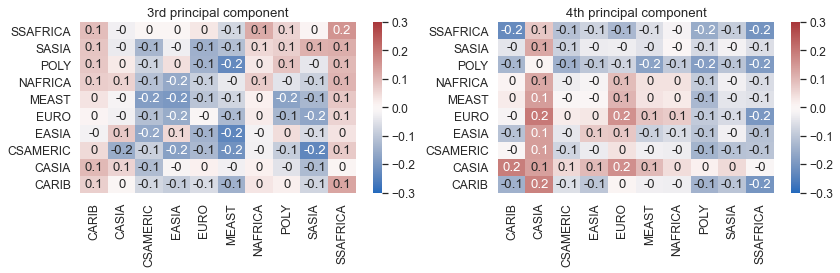

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_fmr(
        components["any", 2], 
        vmin=-0.3, 
        vmax=0.3, 
        title=f"3rd principal component",
        new_figure=False,
    )
plt.subplot(1, 2, 2)
plot_fmr(
        components["any", 3], 
        vmin=-0.3, 
        vmax=0.3, 
        title=f"4th principal component",
        new_figure=False,
    )
plt.savefig(output_dir / "frvt_11_region_pca_3_4.jpg", dpi=100)

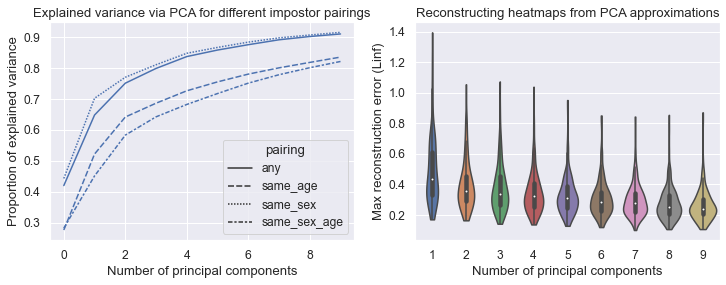

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.lineplot(x="n", y="var", style="pairing", data=pca_df)
plt.xlabel("Number of principal components")
plt.ylabel("Proportion of explained variance")
plt.title("Explained variance via PCA for different impostor pairings")

plt.subplot(1, 2, 2)
sns.violinplot(x="n", y="max", data=err_df.query("pairing == 'any'"), cut=0)
plt.xlabel("Number of principal components")
plt.ylabel("Max reconstruction error (Linf)")
plt.title("Reconstructing heatmaps from PCA approximations")

plt.savefig(output_dir / "frvt_11_region_pca_var_error.jpg", dpi=100)

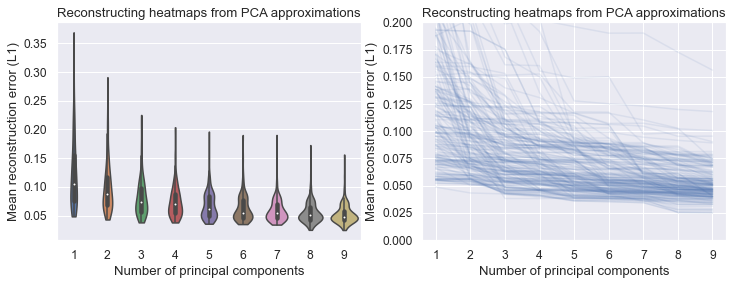

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.violinplot(x="n", y="mean", data=err_df.query("pairing == 'any'"), cut=0)
plt.xlabel("Number of principal components")
plt.ylabel("Mean reconstruction error (L1)")
plt.title("Reconstructing heatmaps from PCA approximations")

plt.subplot(1, 2, 2)
# sns.lineplot(x="n", y="max", hue="pairing", style="diag_only", data=err_df)
sns.lineplot(
    x="n", 
    y="mean", 
    style="algorithm", 
    alpha=0.1, 
    markers=False, 
    dashes=False, 
    ci=None, 
    legend=False,
    data=err_df.query("pairing == 'any'"),
)
plt.xticks(range(1, 10))
plt.ylim((0, 0.2))
plt.xlabel("Number of principal components")
plt.ylabel("Mean reconstruction error (L1)")
plt.title("Reconstructing heatmaps from PCA approximations")

plt.savefig(output_dir / "frvt_11_region_pca_error_any.jpg", dpi=100)